In [7]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [9]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred) # 아래 evaluation_trte를 보면 실제Y값(Y_real)을 데이터프레임으로 입력받았기 때문에 다시 array로 변환하고 flatten함, 예측Y값(Y_pred)은 array를 flatten한 값으로 입력받기때문에 추가변환 없음     
    if loss_length != 0:                                     # 잔차값 array길이가 0이 아니면 실제Y값을 길이를 줄여준다. 
        Y_real = Y_real[loss_length:]                        
    if graph_on == True:                                     
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6), # 실제Y값(Y_real)은 flattenee된 array이니까 다시 데이터프레임으로 변환하고 실제값(Y_real)의 index과 동일하게 indexing하고 concat한다.
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [10]:
# Data Loading
raw_2020 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2020.csv', index_col='DT')
raw_2021 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2021.csv', index_col='DT')
raw_2022 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2022.csv', index_col='DT')

In [11]:
# Data Merge & datetime
raw_all = pd.concat([raw_2020, raw_2021, raw_2022])
raw_uni=raw_all.loc[:, ['ARRIVE_PPL']]
raw_uni.index = pd.to_datetime(raw_uni.index)
raw_uni=raw_uni.dropna()

## MLP

In [12]:
# Parameters
criteria = '2022-02-28'
scaler = preprocessing.MinMaxScaler()
sequence = 30
batch_size = 16
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_uni.loc[raw_uni.index < criteria, :]
test = raw_uni.loc[raw_uni.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


## X/Y Split
X_train, Y_train = [], []
X_test, Y_test = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])                  

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

Train_size: (789, 1) Test_size: (60, 1)
X_train: (759, 30, 1) Y_train: (759, 1)
X_test: (30, 30, 1) Y_test: (30, 1)
X_train: (759, 30) Y_train: (759, 1)
X_test: (30, 30) Y_test: (30, 1)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)          

2022-06-07 14:30:44.462610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 14:30:44.462814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2022-06-07 14:30:44.675896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-07 14:30:44.862043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 12ms/step - loss: 0.0279
Epoch 2/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 3/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 7/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 8/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 9/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 10/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 11/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 12/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 13/20
48/48 [==============================] - 0s 4ms

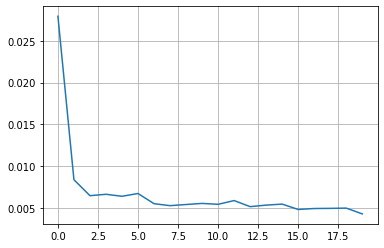

1/1 [==============================] - 0s 66ms/step - loss: 0.0000e+00


2022-06-07 14:30:49.671207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 14:30:49.823764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,MAE,MSE,MAPE
Train,"2,238.21","10,029,714.94",inf
Test,"3,493.43","25,506,622.44",8.38


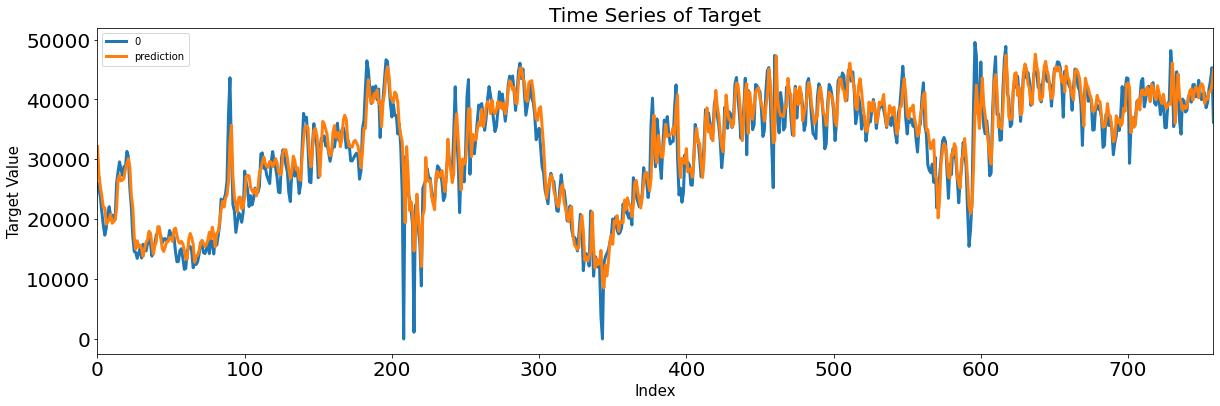

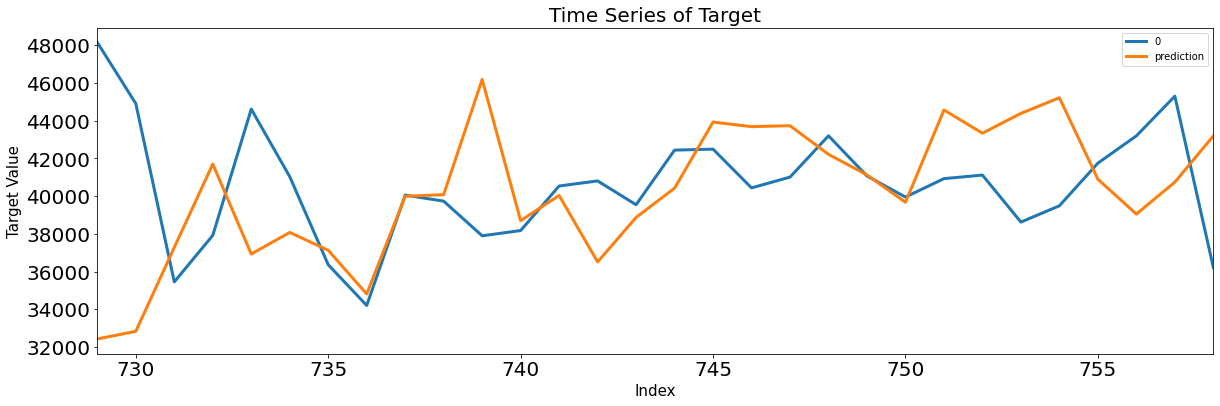

In [13]:
# Layer Network 
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)

# visualization
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(),
                                                      pd.DataFrame(Y_train), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

## RNN

Train_size: (789, 1) Test_size: (60, 1)
X_train: (759, 30, 1) Y_train: (759, 1)
X_test: (30, 30, 1) Y_test: (30, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 128)           16640     
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 256)           98560     
                                                                 
 dropout_5 (Dropout)         (None, 30, 256)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 128)           49280     
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
    

2022-06-07 14:30:51.215696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 74s 2s/step - loss: 0.0434
Epoch 2/20
48/48 [==============================] - 72s 1s/step - loss: 0.0126
Epoch 3/20
48/48 [==============================] - 72s 2s/step - loss: 0.0112
Epoch 4/20
48/48 [==============================] - 73s 2s/step - loss: 0.0099
Epoch 5/20
48/48 [==============================] - 72s 2s/step - loss: 0.0101
Epoch 6/20
48/48 [==============================] - 72s 2s/step - loss: 0.0077
Epoch 7/20
48/48 [==============================] - 72s 2s/step - loss: 0.0072
Epoch 8/20
48/48 [==============================] - 72s 1s/step - loss: 0.0071
Epoch 9/20
48/48 [==============================] - 72s 2s/step - loss: 0.0070
Epoch 10/20
48/48 [==============================] - 72s 2s/step - loss: 0.0060
Epoch 11/20
48/48 [==============================] - 74s 2s/step - loss: 0.0059
Epoch 12/20
48/48 [==============================] - 72s 1s/step - loss: 0.0057
Epoch 13/20
48/48 [==============================] - 72s 1s/

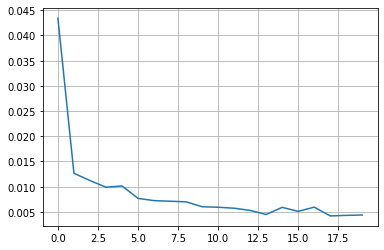

2022-06-07 15:01:13.055660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 15:01:22.754238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 742ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"2,037.54","8,391,146.13",inf
Test,"2,661.84","11,105,558.27",6.61


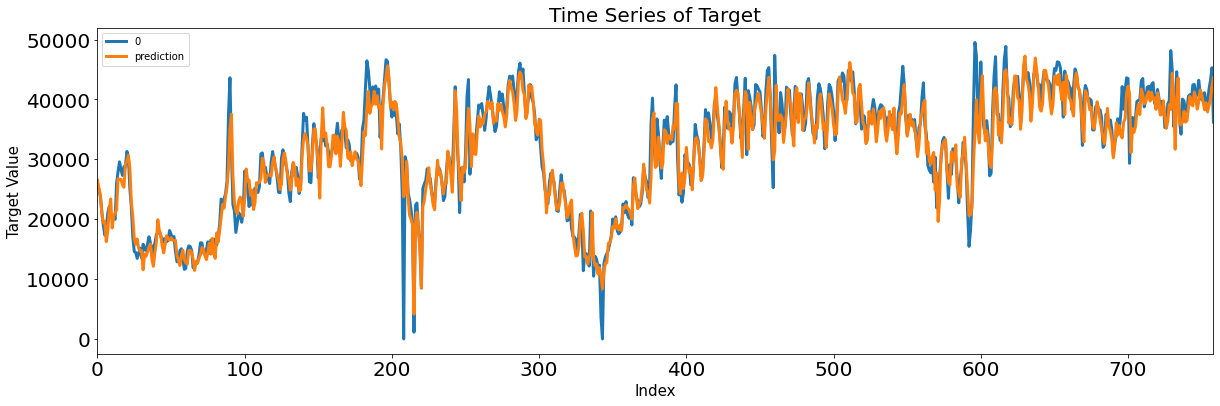

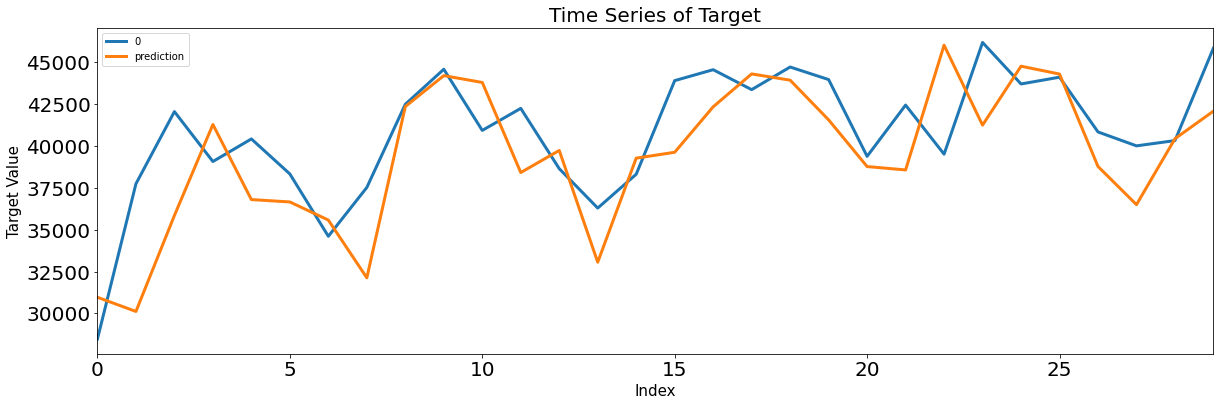

In [14]:
# Parameters
criteria = '2022-02-28'
scaler = preprocessing.MinMaxScaler()
sequence = 30
batch_size = 16
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_uni.loc[raw_uni.index < criteria, :]
test = raw_uni.loc[raw_uni.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X/Y Split
X_train, Y_train = [], []
X_test, Y_test = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])         

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

## LSTM

Train_size: (789, 1) Test_size: (60, 1)
X_train: (759, 30, 1) Y_train: (759, 1)
X_test: (30, 30, 1) Y_test: (30, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           394240    
                                                                 
 dropout_9 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_10 (Dropout)        (None, 30, 128)           0         
    

2022-06-07 15:01:26.180520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 297s 6s/step - loss: 0.0908
Epoch 2/20
48/48 [==============================] - 293s 6s/step - loss: 0.0211
Epoch 3/20
48/48 [==============================] - 296s 6s/step - loss: 0.0178
Epoch 4/20
48/48 [==============================] - 296s 6s/step - loss: 0.0177
Epoch 5/20
48/48 [==============================] - 295s 6s/step - loss: 0.0174
Epoch 6/20
48/48 [==============================] - 297s 6s/step - loss: 0.0162
Epoch 7/20
48/48 [==============================] - 298s 6s/step - loss: 0.0148
Epoch 8/20
48/48 [==============================] - 295s 6s/step - loss: 0.0166
Epoch 9/20
48/48 [==============================] - 297s 6s/step - loss: 0.0147
Epoch 10/20
48/48 [==============================] - 303s 6s/step - loss: 0.0142
Epoch 11/20
48/48 [==============================] - 290s 6s/step - loss: 0.0143
Epoch 12/20
48/48 [==============================] - 297s 6s/step - loss: 0.0137
Epoch 13/20
48/48 [=============================

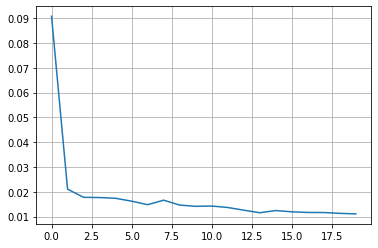

2022-06-07 16:39:57.527410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 16:40:08.664298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 802ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"3,924.86","27,792,449.69",inf
Test,"4,855.49","31,221,372.09",11.65


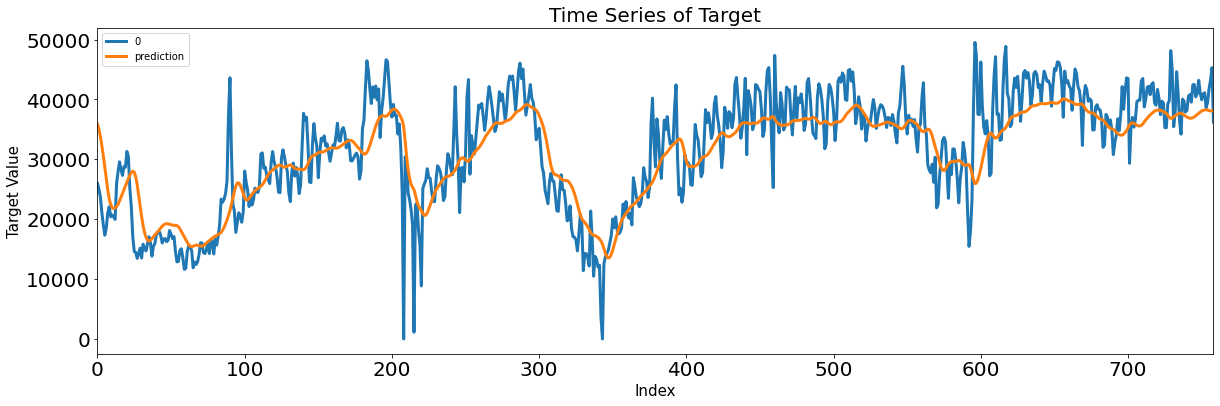

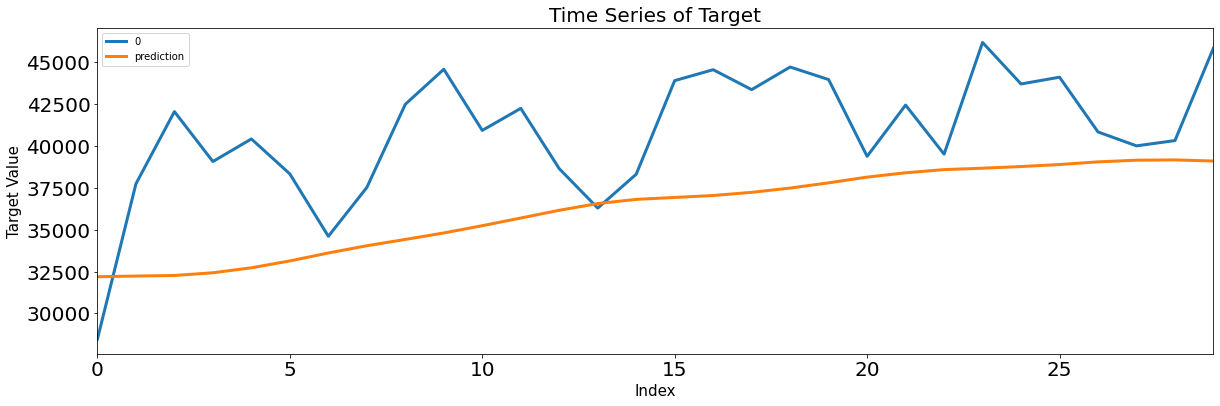

In [15]:
# Parameters
criteria = '2022-02-28'
scaler = preprocessing.MinMaxScaler()
sequence = 30
batch_size = 16
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_uni.loc[raw_uni.index < criteria, :]
test = raw_uni.loc[raw_uni.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)

# visulaization
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

## GRU

Train_size: (789, 1) Test_size: (60, 1)
X_train: (759, 30, 1) Y_train: (759, 1)
X_test: (30, 30, 1) Y_test: (30, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           50304     
                                                                 
 dropout_12 (Dropout)        (None, 30, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 30, 256)           296448    
                                                                 
 dropout_13 (Dropout)        (None, 30, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 30, 128)           148224    
                                                                 
 dropout_14 (Dropout)        (None, 30, 128)           0         
    

2022-06-07 16:40:12.951664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 334s 7s/step - loss: 0.0685
Epoch 2/20
48/48 [==============================] - 334s 7s/step - loss: 0.0115
Epoch 3/20
48/48 [==============================] - 331s 7s/step - loss: 0.0108
Epoch 4/20
48/48 [==============================] - 330s 7s/step - loss: 0.0103
Epoch 5/20
48/48 [==============================] - 231s 5s/step - loss: 0.0094
Epoch 6/20
48/48 [==============================] - 169s 4s/step - loss: 0.0092
Epoch 7/20
48/48 [==============================] - 169s 4s/step - loss: 0.0088
Epoch 8/20
48/48 [==============================] - 170s 4s/step - loss: 0.0080
Epoch 9/20
48/48 [==============================] - 168s 4s/step - loss: 0.0072
Epoch 10/20
48/48 [==============================] - 170s 4s/step - loss: 0.0066
Epoch 11/20
48/48 [==============================] - 172s 4s/step - loss: 0.0059
Epoch 12/20
48/48 [==============================] - 172s 4s/step - loss: 0.0058
Epoch 13/20
48/48 [=============================

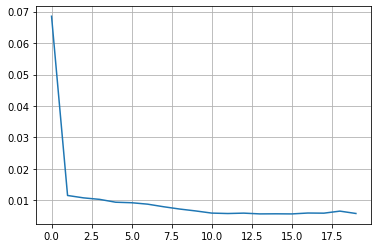

2022-06-07 18:01:43.527834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 18:01:55.876700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 866ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,"2,890.35","15,566,077.57",inf
Test,"2,688.22","10,714,792.36",6.72


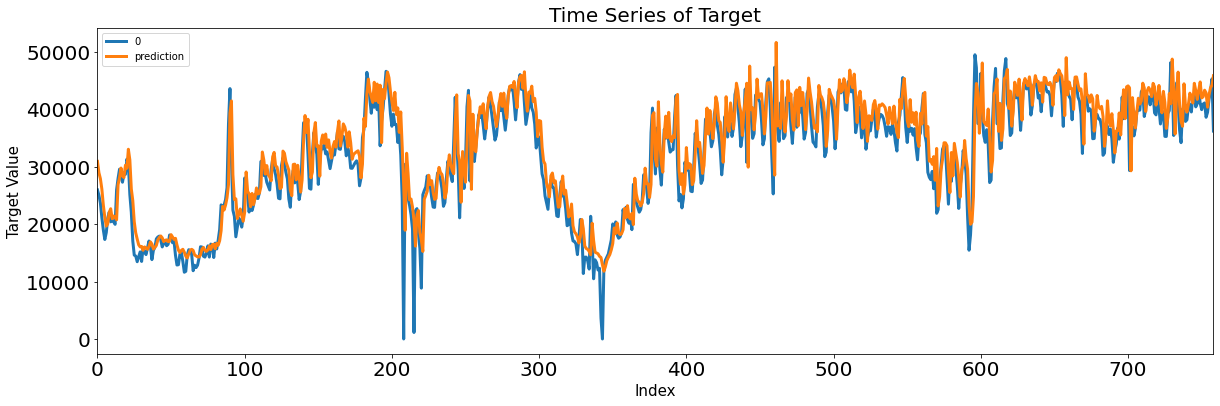

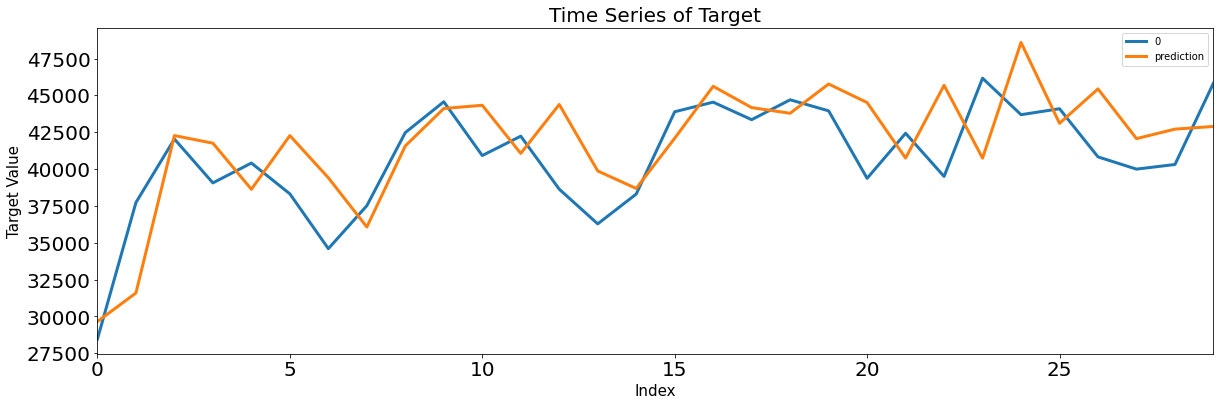

In [16]:
# Parameters
criteria = '2022-02-28'
scaler = preprocessing.MinMaxScaler()
sequence = 30
batch_size = 16
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_uni.loc[raw_uni.index < criteria, :]
test = raw_uni.loc[raw_uni.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)